In [1]:
import jax
import jax.numpy as jnp
from fbpinns.problems import Problem

In [ ]:
class HeatEquation1D(Problem):
    """
    Solves the 1D heat equation:
    
        u_t = α u_xx

    on the domain x ∈ [0, 1] and t ∈ [0, T],
    with homogeneous Dirichlet boundary conditions:
        u(0,t) = u(1,t) = 0
    and initial condition:
        u(x,0) = sin(πx)

    The analytical solution is:
        u(x,t) = sin(πx) * exp(-α π² t)
    """

    @staticmethod
    def init_params(alpha=1.0, N=40000):
        static_params = {
            "dims": (1, 2),  # u is scalar, x and t are the input dimensions.
            "alpha": alpha,
        }
        trainable_params = {
            'attention': jnp.zeros((N, 1))
            }
        return static_params, trainable_params

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # Sample interior points for the physics loss.
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        # Request second derivative with respect to x (index 0) and first derivative with respect to t (index 1)
        required_ujs_phys = (
            (0, (0, 0)),  # u_xx
            (0, (1,)),    # u_t
        )
        # Physics constraints as a single group.
        return [[x_batch_phys, required_ujs_phys]]

    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        """
        Enforces the Dirichlet BCs and the initial condition.
        Assumes x_batch has two columns: x and t.
        Constructs the solution as:
            u(x,t) = x*(1-x)*t * u + sin(πx)
        so that:
            u(x,0) = sin(πx),
            u(0,t) = 0, and
            u(1,t) = 0.
        """
        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        tanh = jax.nn.tanh
        sd = 0.1
        return tanh((-x)/sd)*tanh((1-x)/sd)*tanh((t)/sd) * u + jnp.sin(jnp.pi * x)

    @staticmethod
    def loss_fn(all_params, constraints):
        # Unpack the constraints.
        # Here constraints[0] is assumed to be: [x_batch, u, u_t, u_xx]
        _, uxx, ut = constraints[0]
        alpha = all_params["static"]["problem"]["alpha"]
        # The physics residual: u_t - α u_xx = 0
        residual = ut - alpha * uxx
        
        selected = all_params["trainable"]["problem"]["selected"].astype(jnp.int32)
        attention = all_params["trainable"]["problem"]["attention"][selected]  # (N,1)
        current_i = all_params["trainable"]["problem"]["current_i"]

        m1 = jnp.mean(residual**2)
        m2 = jnp.mean(((jnp.exp(-current_i)+attention)*residual)**2)
        jax.debug.print("curr_i = {i}, raw MSE = {m1:.6f}, weighted MSE = {m2:.6f}", i=current_i, m1=m1, m2=m2)
        jax.debug.print("residual max = {a}, attention head = {b}", a=jnp.max(jnp.abs(residual)), b=attention[:5, 0])
        
        return jnp.mean(
            # ((jnp.exp(-current_i)+attention)*residual) ** 2
            residual ** 2
            ), residual

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        alpha = all_params["static"]["problem"]["alpha"]
        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        return jnp.sin(jnp.pi * x) * jnp.exp(-alpha * (jnp.pi ** 2) * t)
    

[INFO] 2025-04-20 16:35:13 - <fbpinns.constants.Constants object at 0x7a5b0f7af380>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.HeatEquation1D'>
problem_init_kwargs: {'alpha': 1.0, 'N': 10000}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([0.  , 0.25, 0.5 , 0.75, 1.  ])], 'subdomain_ws': [array([0.725, 0.725, 0.725, 0.725, 0.725]), array([0.725, 0.725, 0.725, 0.725, 0.725])], 'unnorm': (0, 1)}
network: <class 'fbpinns.networks.ChebyshevKAN'>
network_init_kwargs: {'input_dim': 2, 'output_dim': 1, 'degree': 9}
n_steps: 10000
scheduler: <class 'fbpinns.schedulers.LineSchedulerRectangularND'>
scheduler_kwargs: {'point': [0.0], 'iaxis': 0}
ns: ((100, 100),)
n_test: (100, 100)
sampler: grid
optimiser: <function adam at 0x7a5ae2517a60>
optimiser_kwargs: {'learn

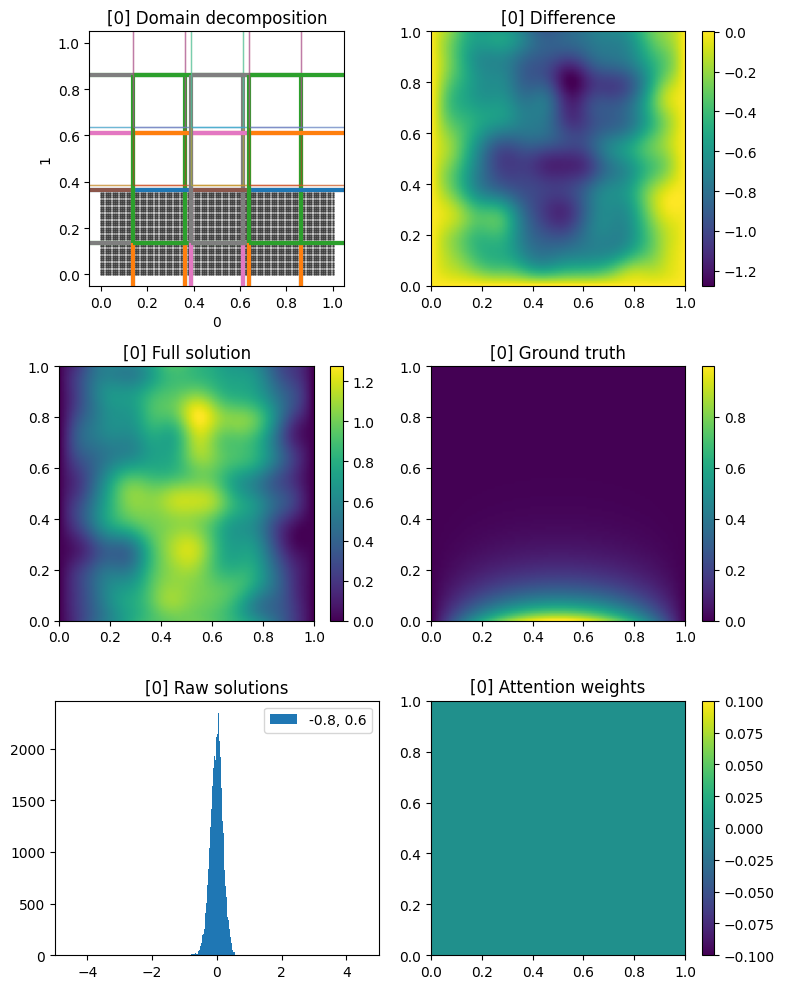

residual max = 82.39348602294922, attention head = [0. 0. 0. 0. 0.]
curr_i = [0.], raw MSE = 781.748474, weighted MSE = 781.748474
residual max = 79.62359619140625, attention head = [0.         0.00041311 0.00078899 0.00111415 0.00137798]
curr_i = [1.], raw MSE = 720.746216, weighted MSE = 100.366776
residual max = 77.5062484741211, attention head = [0.         0.00081554 0.00155575 0.00219358 0.00270787]
curr_i = [2.], raw MSE = 676.626831, weighted MSE = 14.396229
residual max = 75.83328247070312, attention head = [0.         0.00120886 0.00230374 0.00324398 0.0039979 ]
curr_i = [3.], raw MSE = 643.239319, weighted MSE = 2.771441
residual max = 74.45577239990234, attention head = [0.         0.00159411 0.0030352  0.00426903 0.0052534 ]
curr_i = [4.], raw MSE = 616.707031, weighted MSE = 0.972815
residual max = 73.2887191772461, attention head = [0.         0.00197198 0.00375167 0.00527121 0.00647795]
curr_i = [5.], raw MSE = 594.903503, weighted MSE = 0.678046
residual max = 72.28077

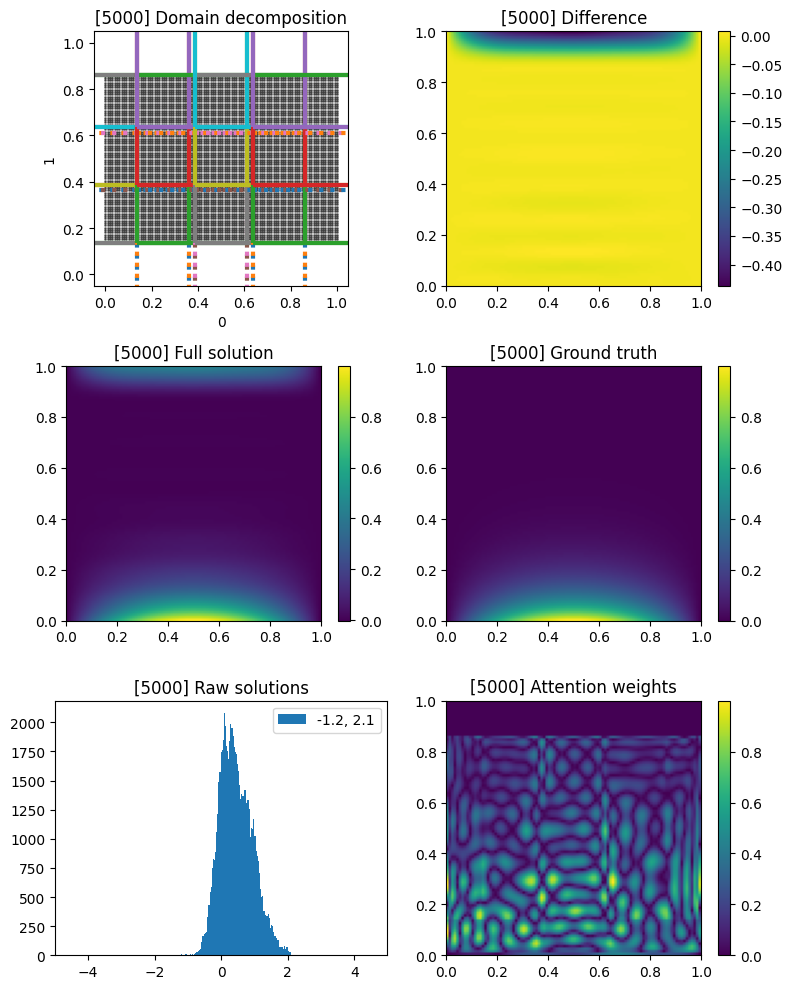

curr_i = [5000.], raw MSE = 0.032473, weighted MSE = 0.008582
residual max = 0.6612597703933716, attention head = [0.73879373 0.5987509  0.46707416 0.33844516 0.2051349 ]
curr_i = [5001.], raw MSE = 0.032470, weighted MSE = 0.008582
residual max = 0.661247968673706, attention head = [0.73880684 0.5987615  0.46708262 0.3384519  0.20514034]
curr_i = [5002.], raw MSE = 0.032467, weighted MSE = 0.008581
residual max = 0.6612367033958435, attention head = [0.73881996 0.59877217 0.46709108 0.3384586  0.20514578]
curr_i = [5003.], raw MSE = 0.032464, weighted MSE = 0.008580
residual max = 0.661224901676178, attention head = [0.73883307 0.59878284 0.46709955 0.3384653  0.20515123]
curr_i = [5004.], raw MSE = 0.032460, weighted MSE = 0.008580
residual max = 0.6612136960029602, attention head = [0.7388461  0.5987935  0.467108   0.338472   0.20515667]
curr_i = [5005.], raw MSE = 0.032457, weighted MSE = 0.008579
residual max = 0.6612024307250977, attention head = [0.7388592  0.5988041  0.46711648

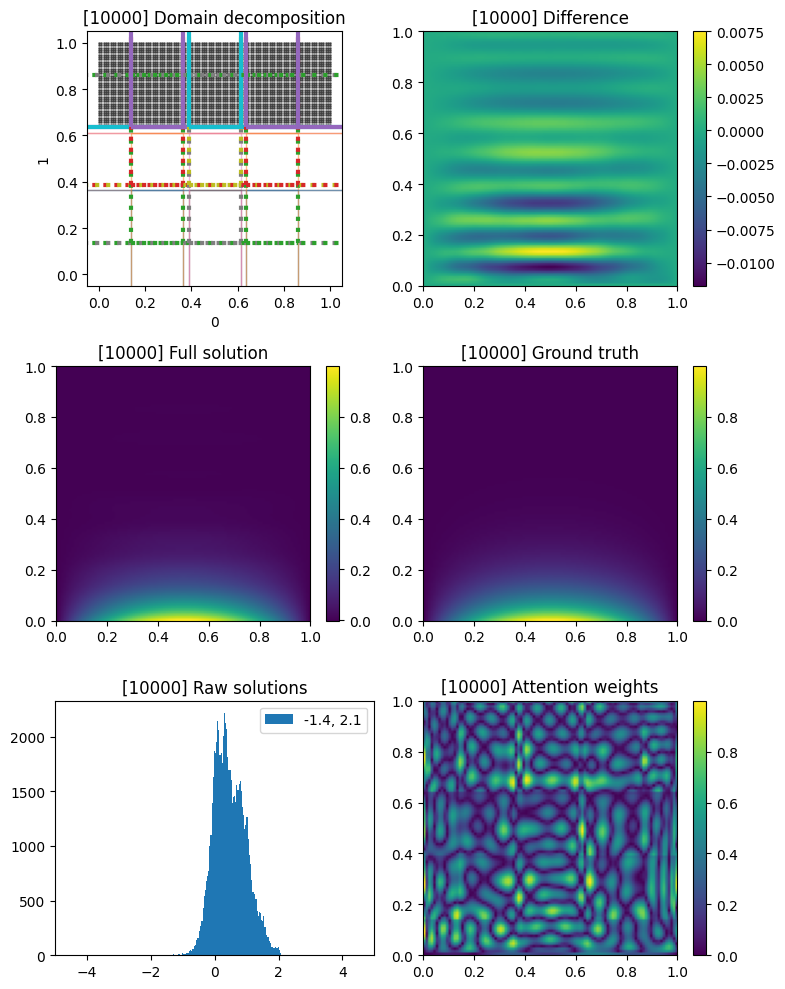

[INFO] 2025-04-20 16:35:56 - [i: 10000/10000] Training complete


In [3]:
import numpy as np
from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

# Set the final time for the simulation
T = 1.0
subdomain_xs=[np.linspace(0,1,5), np.linspace(0,1,5)]

# Create a Constants object to hold all hyperparameters
c = Constants(
    # Define the problem domain (x and t)
    domain=RectangularDomainND,
    domain_init_kwargs=dict(
        xmin=np.array([0.0, 0.0]),  # x in [0, 1] and t in [0, T]
        xmax=np.array([1.0, T])
    ),
    # Set the problem to our heat equation
    problem=HeatEquation1D,
    problem_init_kwargs=dict(
        alpha=1.0,
        N=100*100
        ),
    # Use a rectangular domain decomposition
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        # Split both x and t into 11 subdomains (you can adjust this as needed)
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0, 1)
    ),
    # Use a fully-connected network; note the input layer size is 2 (x and t)
    # network=FCN,
    # network_init_kwargs=dict(
    #     layer_sizes=(2, 32, 1)
    # ),
    network=ChebyshevKAN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=1,
        degree=9
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    # Number of training collocation points and testing points
    # ns=((200,),),
    # n_test=(500,),
    ns=((100,100),),
    n_test=(100,100),
    # Set training steps and optimizer parameters
    n_steps=10000,
    # optimiser_kwargs=dict(learning_rate=1e-3),
    clear_output=False,
    attention_tracking=True,
)

# Create the trainer and start training
run = FBPINNTrainer(c)
all_params = run.train()

In [4]:
all_params

{'static': {'domain': {'xd': 2,
   'xmin': Array([0., 0.], dtype=float32),
   'xmax': Array([1., 1.], dtype=float32)},
  'problem': {'dims': (1, 2), 'alpha': 1.0},
  'decomposition': {'m': 25,
   'xd': 2,
   'subdomain': {'params': [Array([[-0.3625, -0.3625],
            [-0.3625, -0.1125],
            [-0.3625,  0.1375],
            [-0.3625,  0.3875],
            [-0.3625,  0.6375],
            [-0.1125, -0.3625],
            [-0.1125, -0.1125],
            [-0.1125,  0.1375],
            [-0.1125,  0.3875],
            [-0.1125,  0.6375],
            [ 0.1375, -0.3625],
            [ 0.1375, -0.1125],
            [ 0.1375,  0.1375],
            [ 0.1375,  0.3875],
            [ 0.1375,  0.6375],
            [ 0.3875, -0.3625],
            [ 0.3875, -0.1125],
            [ 0.3875,  0.1375],
            [ 0.3875,  0.3875],
            [ 0.3875,  0.6375],
            [ 0.6375, -0.3625],
            [ 0.6375, -0.1125],
            [ 0.6375,  0.1375],
            [ 0.6375,  0.3875],
    